# ROC_all

Generate receiver operating characteristic curves for ALL CNNs, PFNs, and BDTs.

Outputs are stored in `<data_dir>/model_outputs/<task_name>_pfn_test.npz`. Keys are `raw_outputs` and `y_true`.

In [142]:
import sys
sys.path.append("..")

from utils import data_dir

import os
import numpy as np
from scipy.special import softmax

from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint

In [95]:
def compute_ROC(raw_outputs, y_true, working_points):
    """
    Inputs:
        - raw_outputs is an N x 3 array of final model outputs.
        - y_true is a list of ints with classes.
    Returns:
        - a list of coordinates (sig_eff, bkg_eff) to comprise a curve.
        - a list of (sig_eff, 1/bkg_eff) for given working points.
    """
    raw_probs = softmax(raw_outputs, axis=1)
    sig_probs = raw_probs[y_true == 2][:,2]
    bkg_probs = raw_probs[y_true < 2][:,2]
    
    def get_thresh(working_point, atol=1e-6):
        # Get threshold given working point using *binary search*!
        # Recall: working point is desired signal efficiency.
        lo = 0
        hi = 1
        while hi - lo > atol:
            mid = (lo + hi) / 2
            if np.mean(sig_probs > mid) > working_point:
                lo = mid
            else:
                hi = mid
        return (lo + hi) / 2

    # Broad curve
    dense_wps = np.linspace(0.95, 1, 200)
    curve = []
    for wp in dense_wps:
        thresh = get_thresh(wp)
        curve.append((np.mean(sig_probs > thresh), np.mean(bkg_probs > thresh)))

    # Specific points
    table = {}
    for wp in working_points:
        thresh = get_thresh(wp)
        sig_eff = np.mean(sig_probs > thresh)
        if abs(sig_eff - wp) > 0.01:
            table[wp] = np.nan
        else:
            table[wp] = 1 / np.mean(bkg_probs > thresh)
    
    return np.array(curve), table

In [101]:
task2label = {
    "scalar1": r"$h_2\rightarrow\pi^0\pi^0$",
    "axion1": r"$a\rightarrow\gamma\gamma$",
    "axion2": r"$a\rightarrow3\pi^0$"
}
wp_format = {
    0.9: "90%",
    0.95: "95%",
    0.99: "99%",
    0.995: "99.5%",
}

What do we need?
- For every class of model (CNN, PFN, BDT),
    - For every task (scalar1, axion1, axion2),
        - For every working point (0.9, 0.95, 0.99, 0.995):
            - Determine rejection rate.

The last one is already done with `compute_ROC(raw_outputs, y_true, working_points)`.

In [102]:
# Index is e.g. ("cnn", "scalar1")
tables = {}
curves = {}

working_points = sorted(list(wp_format.keys()))
for model in ["cnn", "bdt", "pfn"]:
    for task_name in ["scalar1", "axion1", "axion2"]:
        outputs = np.load(f"{data_dir}/model_outputs/{task_name}_{model}_test.npz")
        raw_outputs = outputs["raw_outputs"]
        y_true = outputs["y_true"]
    
        curve, table = compute_ROC(raw_outputs, y_true, working_points)
        curves[(model, task_name)] = curve
        tables[(model, task_name)] = table

In [103]:
pprint(tables)

{('bdt', 'axion1'): {0.9: 188.08777429467085,
                     0.95: 57.69230769230769,
                     0.99: 7.482229704451927,
                     0.995: 4.440168726411604},
 ('bdt', 'axion2'): {0.9: 253.1645569620253,
                     0.95: 89.68609865470852,
                     0.99: 9.514747859181732,
                     0.995: 4.794246903715541},
 ('bdt', 'scalar1'): {0.9: 143.54066985645932,
                      0.95: 40.84411164057182,
                      0.99: 5.422503389064618,
                      0.995: 3.3785686130975843},
 ('cnn', 'axion1'): {0.9: 19944.333333333332,
                     0.95: 3324.0555555555557,
                     0.99: 19.917776298268972,
                     0.995: 10.740082570454138},
 ('cnn', 'axion2'): {0.9: nan,
                     0.95: 59885.0,
                     0.99: 1618.5135135135135,
                     0.995: 165.8864265927978},
 ('cnn', 'scalar1'): {0.9: 19967.666666666668,
                      0.95: 14975.749999

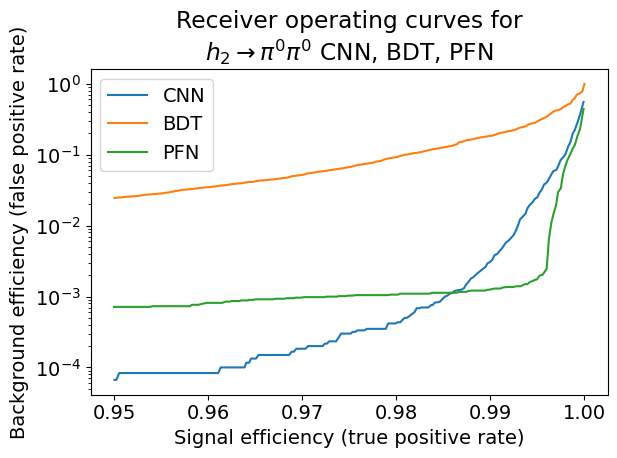

In [159]:
# Focus on one task
for task_name in ["axion1", "axion2", "scalar1"]:
    plt.close()
    
    for model in ["cnn", "bdt", "pfn"]:
        curve = curves[(model, task_name)]
        plt.plot(*curve.T, label=model.upper())

    plt.title(f"Receiver operating curves for\n{task2label[task_name]} CNN, BDT, PFN")
    plt.yscale("log")
    plt.legend()
    
    plt.rcParams.update({'font.size': 14})
    plt.xlabel("Signal efficiency (true positive rate)")
    plt.ylabel("Background efficiency (false positive rate)")
    
    os.makedirs("./compare_results", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"./compare_results/{task_name}_ROC_curves.pdf")

In [157]:
# Formatting working points for the table
print(f"working points: {working_points}")
columns = working_points

def sanitize(latex_str):
    return latex_str.replace("%", r"\%")

def format_rej_rate(rej_rate):
    if np.isnan(rej_rate):
        return "N/A"
    return f"{rej_rate:.0f}"

header = ["Model"] + [rf"$\text{{Rej}}_{{{sanitize(wp_format[wp])}}}$" for wp in columns]
table = []
for task_name in ["scalar1", "axion1", "axion2"]:
    for model in ["cnn", "bdt", "pfn"]:
        row = [f"{model.upper()} ({task2label[task_name]})"] + [format_rej_rate(tables[(model, task_name)][wp]) for wp in columns]
        table.append(row)

print()
print(tabulate(table, headers=header, tablefmt="latex_raw"))

working points: [0.9, 0.95, 0.99, 0.995]

\begin{tabular}{lllrr}
\hline
 Model                            & $\text{Rej}_{90\%}$   & $\text{Rej}_{95\%}$   &   $\text{Rej}_{99\%}$ &   $\text{Rej}_{99.5\%}$ \\
\hline
 CNN ($h_2\rightarrow\pi^0\pi^0$) & 19968                 & 14976                 &                   327 &                      39 \\
 BDT ($h_2\rightarrow\pi^0\pi^0$) & 144                   & 41                    &                     5 &                       3 \\
 PFN ($h_2\rightarrow\pi^0\pi^0$) & 2406                  & 1399                  &                   802 &                     573 \\
 CNN ($a\rightarrow\gamma\gamma$) & 19944                 & 3324                  &                    20 &                      11 \\
 BDT ($a\rightarrow\gamma\gamma$) & 188                   & 58                    &                     7 &                       4 \\
 PFN ($a\rightarrow\gamma\gamma$) & N/A                   & N/A                   &                  1200 &    